# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1ainIox2xzXZFMkwQxSiXzf5lWaAwfDyO?usp=drive_link

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:02<00:00, 77616183.33it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

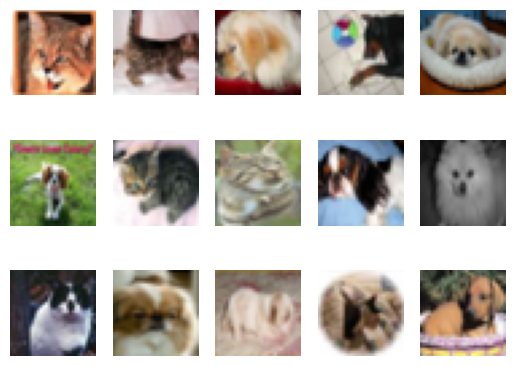

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [5]:
sets = [train_loader, test_loader, val_loader]
for i in sets:
  print(len(i))

#From the output below we can see we have 8000 training examples, 2000 testing examples and 2000 validation examples

8000
2000
2000


From the output above we can see we have 8000 training examples, 2000 testing examples and 2000 validation examples in the combined dog and cat classes.

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

Since we get our model to learn the dataset based on the training examples, there is a higher likelihood of the model being overfitted to the data producing low loss/error as compared to when it would be run on examples it hasn't seen before (like those in the validation set). The validation set also provides us an opportunity to explore the true performance capabilities of the model when it is exposed to new data similar to a real world setting and tune the hyperparameters accordingly to increase accuracy.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [6]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [9]:
#Using numel from Lab 1 to find number of elements (parameters) in tensor (network)
total_paramters_small = 0
for param in small_net.parameters():
    print(param.shape)
    parameters_small = param.numel()
    total_paramters_small += parameters_small
print("Total paramters in small_net : ", total_paramters_small)

total_paramters_large = 0
for param in large_net.parameters():
    print(param.shape)
    parameters_large = param.numel()
    total_paramters_large += parameters_large
print("Total paramters in large_net : ", total_paramters_large)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
Total paramters in small_net :  386
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
Total paramters in large_net :  9705


Total paramters in small_net :  386

Total paramters in large_net :  9705

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [10]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [ ]:
#The function definition contains all the answers for this question in the line below
#def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):

#The default values are, batch_size = 64, learning_rate = 0.01, num_epochs = 30.

The default values are, batch_size = 64, learning_rate = 0.01, num_epochs = 30.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [11]:
train_net(small_net, 64, 0.01, 5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.416125, Train loss: 0.6714658460617066 |Validation err: 0.373, Validation loss: 0.6541851703077555
Epoch 2: Train err: 0.36825, Train loss: 0.6417813982963562 |Validation err: 0.3745, Validation loss: 0.6538403276354074
Epoch 3: Train err: 0.34275, Train loss: 0.6244836616516113 |Validation err: 0.3405, Validation loss: 0.6199461929500103
Epoch 4: Train err: 0.329875, Train loss: 0.6090887966156006 |Validation err: 0.3605, Validation loss: 0.6276408210396767
Epoch 5: Train err: 0.317625, Train loss: 0.6000747032165528 |Validation err: 0.322, Validation loss: 0.6144496481865644
Finished Training
Total time elapsed: 22.39 seconds


Files written to disk during execution-

model_small_bs64_lr0.01_epoch0 - model saved post 1st epoch

model_small_bs64_lr0.01_epoch1 - model saved post 2nd epoch

model_small_bs64_lr0.01_epoch2 - model saved post 3rd epoch

model_small_bs64_lr0.01_epoch3 - model saved post 4th epoch

model_small_bs64_lr0.01_epoch4 - model saved post 5th epoch

model_small_bs64_lr0.01_epoch4_train_err.csv - training error for all epochs

model_small_bs64_lr0.01_epoch4_train_loss.csv - training loss for all epochs

model_small_bs64_lr0.01_epoch4_val_err.csv - validation error for all epochs

model_small_bs64_lr0.01_epoch4_val_loss.csv - validation loss for all epochs

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [12]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
small_net = SmallNet()
large_net = LargeNet()

#using default parameters to train small_net
train_net(small_net, 64, 0.01, 30)

#using default parameters to train large_net
train_net(large_net, 64, 0.01, 30)

#Training times
#small_net -> Total time elapsed: 147.74 seconds
#large_net -> Total time elapsed: 162.37 seconds

#The large_net network seems to take a little longer than the small_net network as a result of the increased number of training parameters as found in part (a) of
#this section of the lab. large_net parameters = 9705 as compared to small_net parameters = 386.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.422375, Train loss: 0.6716891074180603 |Validation err: 0.3735, Validation loss: 0.6535317860543728
Epoch 2: Train err: 0.362875, Train loss: 0.6403266997337341 |Validation err: 0.3635, Validation loss: 0.6488472539931536
Epoch 3: Train err: 0.34425, Train loss: 0.6254545783996582 |Validation err: 0.3455, Validation loss: 0.6203189175575972
Epoch 4: Train err: 0.331125, Train loss: 0.6105487518310547 |Validation err: 0.3525, Validation loss: 0.6239588130265474
Epoch 5: Train err: 0.3255, Train loss: 0.6031277022361755 |Validation err: 0.333, Validation loss: 0.6160122845321894
Epoch 6: Train err: 0.3135, Train loss: 0.5945649976730347 |Validation err: 0.3305, Validation loss: 0.6118946485221386
Epoch 7: Train err: 0.316625, Train loss: 0.5917581415176392 |Validation err: 0.3335, Validation loss: 0.6110464800149202
Epoch 8: Train err: 0.309125, Train loss: 0.58613898229599 |Validation err: 

small_net -> Total time elapsed: 147.74 seconds

large_net -> Total time elapsed: 162.37 seconds

The large_net network seems to take a little longer than the small_net network as a result of the increased number of training parameters as found in part (a) of this section of the lab. large_net parameters = 9705 as compared to small_net parameters = 386.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Small_Net Curve Plots -

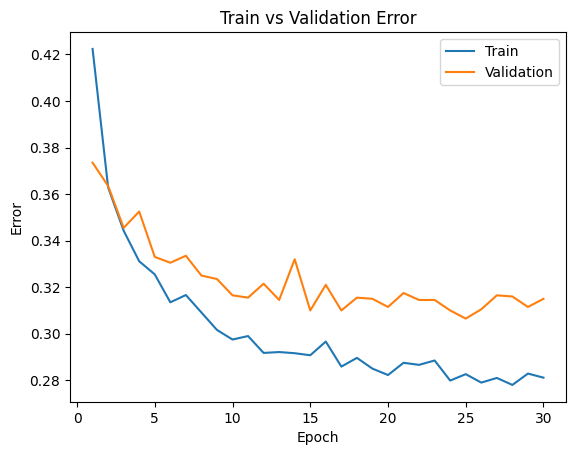

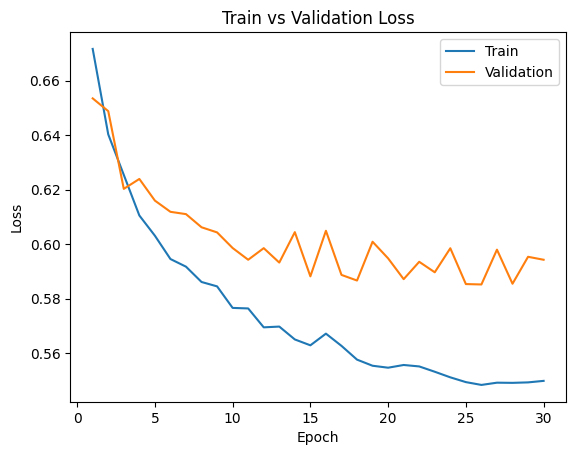

None


In [16]:
#Trajectory of training/validation error and training/validation loss in small_net
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
print(plot_training_curve(model_path))

Large_Net Curve Plots -

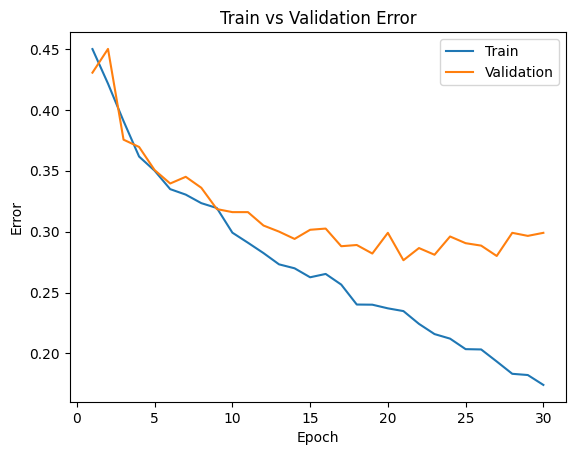

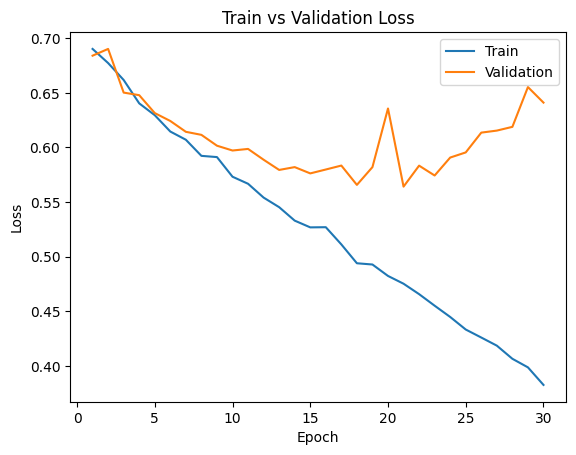

None


In [17]:
#Trajectory of training/validation error and training/validation loss in large_net
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
print(plot_training_curve(model_path))

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**Mentioned below are a set of differences observed between the training and validation curves of the two models -**

The training error in the case of small_net is initially larger than that of large_net for the first 5-7 epochs, but this error reduces a lot quicker until both small and large net produce equivalent error at 8-10 epochs. After this initial rapid error lowering rate, it then decreases a lot slower than in the case of small_net (only going from 0.2975 to 0.28115 between epochs 10 and 30), as compared to large_net which decreases uniformly post the 10th epoch all the way down to 0.174125 in the 30th epoch.

It can also be noted that the validation error curves for both models follow a similar pattern with a slight offset and end up at a difference of 0.02 post the 30th epoch, with large_net prodcuing a lower validation error.

There is a case of underfitting in small_net as there is a decrease in both the training and validation error and loss curves until close to the 15th epoch, after which the loss values fluctuate but don't actually reduce that much, seeming to be held within constant bounds. This fluctuation can also be attributed to underfitting but is a lot less obvious than before the 15th epoch.

As for large_net, the training and validation error and loss seem to curve downwards until the 20th epoch where the validation loss seems to suddenly jump up and start increasing again while the validation error seems to stabalize. Up until the 20th epoch, this is once again a case of underfitting similar to the small_net case. However, post the 20th epoch this is a severe case of overfitting as the training error and loss keep decreasing further but the validation loss jumps back up, and the validation error also starts to be constant post that point.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

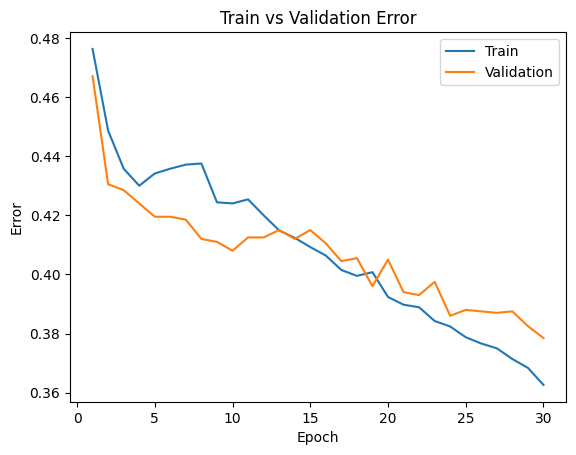

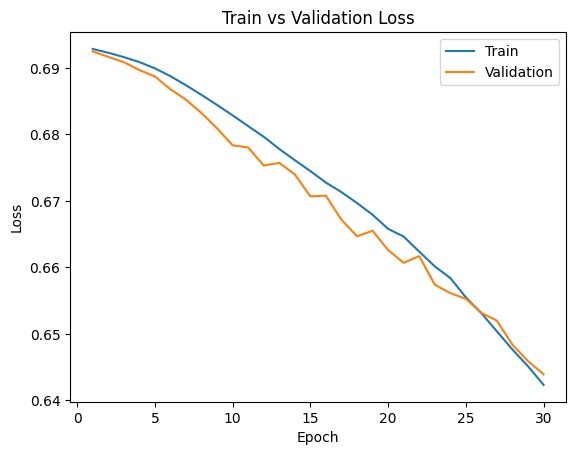

None


In [18]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
print(plot_training_curve(model_path))

Lowering the learning rate to 0.001 from 0.01 causes the model to take 3 seconds longer (165 sec vs 162 sec) as compared to the default case.

The main difference from the default case is that there is no more overfitting all through the 30 epochs as both the training and validation error and loss curves follow a simialr downward curve. However, it is important to note that both the training error and validation errors are now significantly higher than the default case; increasing from 0.17 to 0.36 in the case of training, and 0.30 to 0.38 in the case of validation after all 30 epochs. The losses are also higher for training comapred to the default case (0.38 vs 0.64), but validation loss remains the same after 30 epochs. All this suggests that 0.001 maybe to low of a learning rate.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

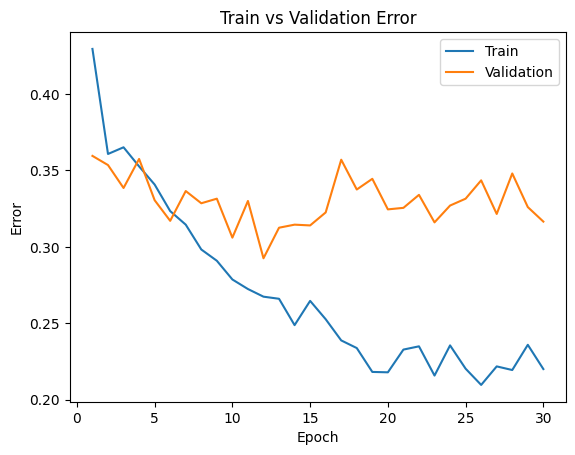

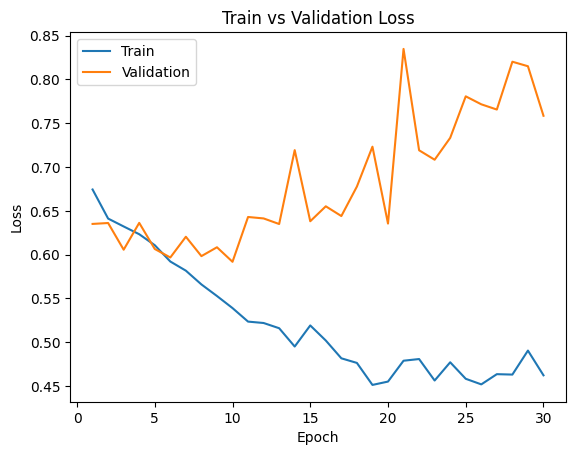

None


In [19]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
print(plot_training_curve(model_path))

Increasing the learning rate to 0.01 from 0.1 causes the model to take 3 seconds longer (165 sec vs 162 sec) as compared to the default case.

The main difference from the default case is that there is now more overfitting, starting as early as the 10th epoch as both the training error and loss curves follow a simialr downward curve but the validation error seems to stop decreasing and only fluctuate within bounds, and the validation loss starts going higher post the 10th epoch. It is also important to note that both the training error and validation errors are now slightly higher than the default case; increasing from 0.17 to 0.22 in the case of training, and 0.30 to 0.32 in the case of validation after all 30 epochs. The losses are also higher for training comapred to the default case (0.46 vs 0.64), and the validation loss is extremely high compared to default after 30 epochs, increasing from 0.64 to 0.76. All this suggests that 0.1 maybe too high of a learning rate.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.6958557292819023 |Validation err: 0.509, Validation loss: 0.6963492184877396
Epoch 2: Train err: 0.49775, Train loss: 0.694276686757803 |Validation err: 0.509, Validation loss: 0.6944219917058945
Epoch 3: Train err: 0.49775, Train loss: 0.6933476105332375 |Validation err: 0.509, Validation loss: 0.6936414539813995
Epoch 4: Train err: 0.49775, Train loss: 0.6929657645523548 |Validation err: 0.509, Validation loss: 0.6932569891214371
Epoch 5: Train err: 0.49775, Train loss: 0.6926678568124771 |Validation err: 0.5075, Validation loss: 0.6928388327360153
Epoch 6: Train err: 0.4925, Train loss: 0.6924372650682926 |Validation err: 0.493, Validation loss: 0.6925397664308548
Epoch 7: Train err: 0.4715, Train loss: 0.6921608597040176 |Validation err: 0.458, Validation loss: 0.6921813935041428
Epoch 8: Train err: 0.44575, Train loss: 0.6917873173952103 |Validation err: 0.4425, V

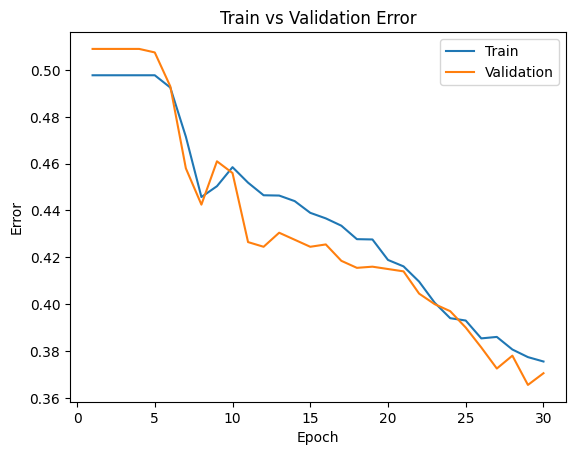

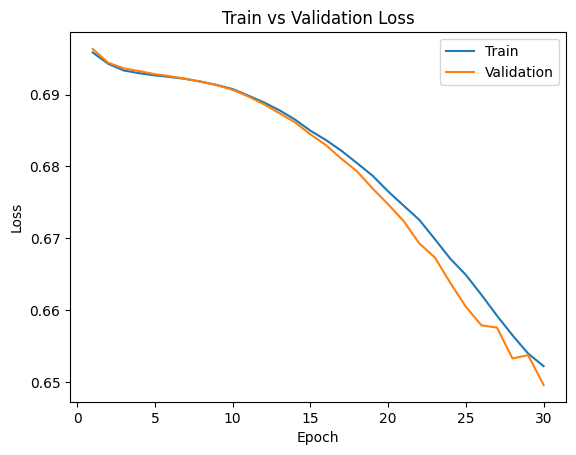

None


In [24]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
print(plot_training_curve(model_path))

Increasing the batch size from 64 to 512 causes the model to take 14 seconds less (148 sec vs 162 sec) as compared to the default case, this might be becuase of the reduced number of iterations required to go through in each epoch.

The main difference from the default case is that there is no more overfitting all through the 30 epochs as both the training and validation error and loss curves follow a simialr downward curve. However, it is important to note that both the training error and validation errors are now significantly higher; increasing from 0.17 to 0.37 in the case of training, and 0.30 to 0.37 in the case of validation after all 30 epochs. The losses are also higher for training comapred to the default case (0.38 vs 0.65), but validation loss remains almost the same (even a small bit lower infact) after 30 epochs.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

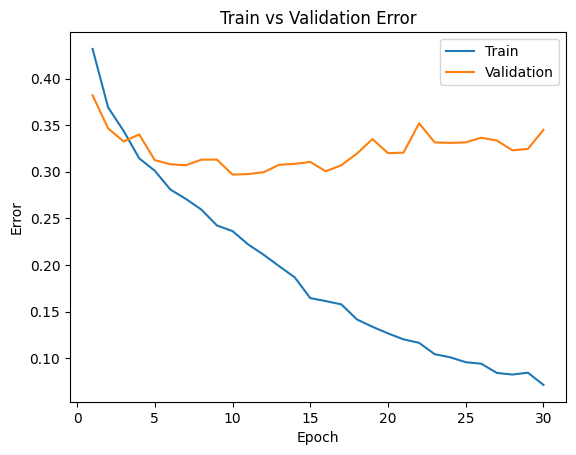

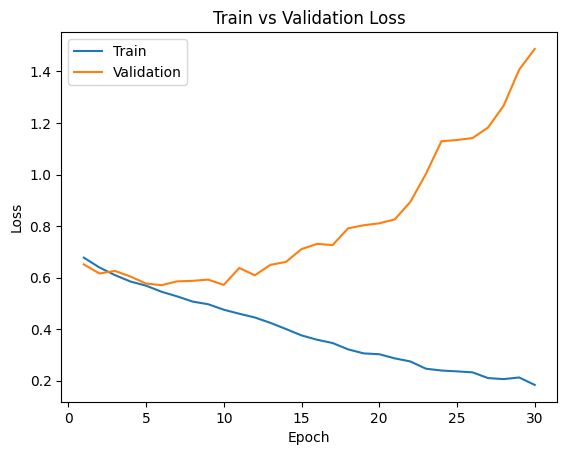

None


In [21]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
print(plot_training_curve(model_path))

Decreasing the batch size from 64 to 16 causes the model to take 73 seconds longer (235 sec vs 162 sec) as compared to the default case, this might be becuase of the increased number of iterations required to go through in each epoch.

The main difference from the default case is that there is now more overfitting, starting as early as the 10th epoch as both the training error and loss curves follow a simialr downward curve but the validation error seems to stop decreasing and only fluctuate within bounds, and the validation loss starts going higher post the 10th epoch. It is also important to note that the training error is significantly lower comapred to default, decreasing from 0.17 to 0.07, but the validation error is now a lot higher than the default case increasing from 0.17 to 0.34 after all 30 epochs. The loss is also lower for training comapred to the default case (0.18 vs 0.46), but once again the validation loss is extremely high compared to default after 30 epochs, increasing from 0.64 to 1.48.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Based on the results of all the different hyperparameter combinations tried in the parts above it seems that the large_net model is a better choice than small_net as it produces lower training and validation errors. It also produces a lower validation loss, suggesting lesser signs of overfitting when compared with other error/loss curves.

A common problem with the large_net model was the presence of overfitting with default hyperparameter settings. A good plan would be to pick 0.01 as the learning rate as it does not overfit to the training data like 0.1 and also doesn't undefit as much as 0.001. It also seems like a batch_size of 512 eliminates the overfitting problem that might be caused as a result of choosing large_net, so that would be my choice over 64 or 16 batch_sizes as they too overfit to the training data, but I think the optimal balance would be achieved by using a batch_size of 256. I would keep the epochs to 30 as it seems to be a good balance that allows getting past the underfitting stage but also preventing overfitting stages. So, large_net, learning rate = 0.01, batch_size = 256, epochs = 30 would be my startegy to reduce the validation error while keeping the validation loss in check, to improve the validation accuracy.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.467625, Train loss: 0.6926687750965357 |Validation err: 0.4355, Validation loss: 0.6918838396668434
Epoch 2: Train err: 0.45125, Train loss: 0.6913921367377043 |Validation err: 0.446, Validation loss: 0.6896143183112144
Epoch 3: Train err: 0.428375, Train loss: 0.6892956402152777 |Validation err: 0.418, Validation loss: 0.6862075850367546
Epoch 4: Train err: 0.432375, Train loss: 0.6857246868312359 |Validation err: 0.4185, Validation loss: 0.6810905262827873
Epoch 5: Train err: 0.425875, Train loss: 0.6823424641042948 |Validation err: 0.414, Validation loss: 0.6774001196026802
Epoch 6: Train err: 0.41775, Train loss: 0.6785750649869442 |Validation err: 0.415, Validation loss: 0.6732205599546432
Epoch 7: Train err: 0.4085, Train loss: 0.6743601486086845 |Validation err: 0.412, Validation loss: 0.6696006879210472
Epoch 8: Train err: 0.401625, Train loss: 0.6709103956818581 |Validation err: 0

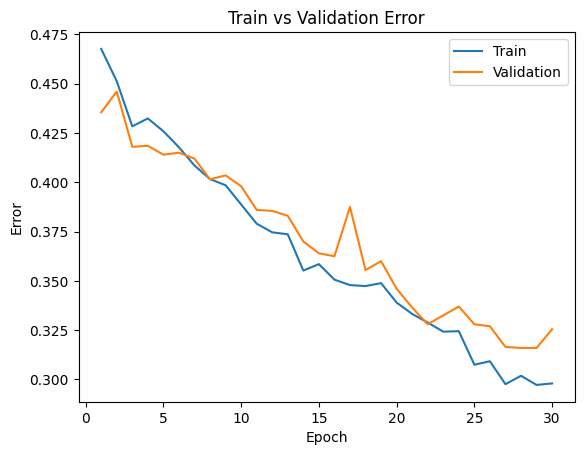

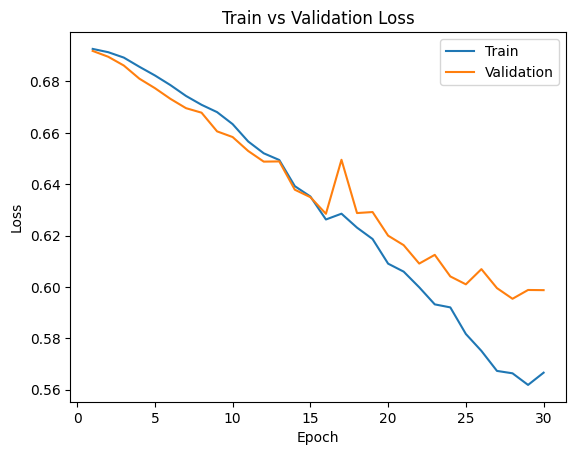

None


In [26]:
large_net = LargeNet()
train_net(large_net, 256, 0.01, 30)
model_path = get_model_name("large", batch_size=256, learning_rate=0.01, epoch=29)
print(plot_training_curve(model_path))

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

It seems from the results above that even though a batch_size of 256 did a good job of reducing the validation error, there is an instance of the beginnings of a overfitting stage at epoch 17, so I would reduce the epochs to 17 now. I also think the learning rate of 0.01 is a bit too low and not decreasing the validation loss quick enough, so I will now change that to 0.025 in order to initiate a quicker decrease in the loss, preventing any overfitting that might be left. So the new set of hyperparameters are now large_net, batch_size = 256, learning_rate = 0.025, epochs = 17.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.459375, Train loss: 0.690877053886652 |Validation err: 0.436, Validation loss: 0.6855586245656013
Epoch 2: Train err: 0.431, Train loss: 0.6801417786628008 |Validation err: 0.4115, Validation loss: 0.6764916107058525
Epoch 3: Train err: 0.4115, Train loss: 0.6716584824025631 |Validation err: 0.375, Validation loss: 0.6580018103122711
Epoch 4: Train err: 0.38025, Train loss: 0.6574407164007425 |Validation err: 0.3665, Validation loss: 0.6428290829062462
Epoch 5: Train err: 0.365125, Train loss: 0.6442770082503557 |Validation err: 0.357, Validation loss: 0.634015865623951
Epoch 6: Train err: 0.357375, Train loss: 0.6335296276956797 |Validation err: 0.3495, Validation loss: 0.6240116059780121
Epoch 7: Train err: 0.358125, Train loss: 0.6309494897723198 |Validation err: 0.354, Validation loss: 0.6277857348322868
Epoch 8: Train err: 0.340625, Train loss: 0.614841278642416 |Validation err: 0.329

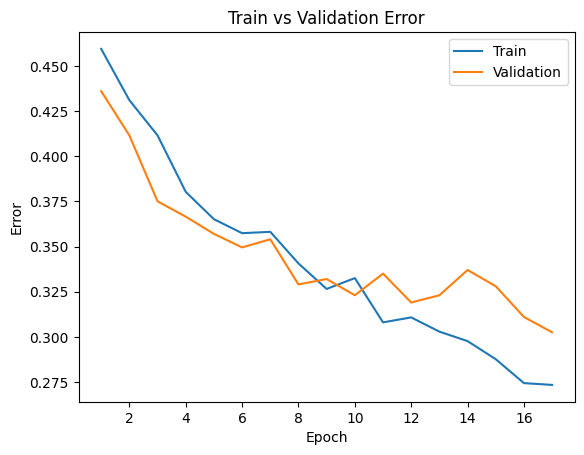

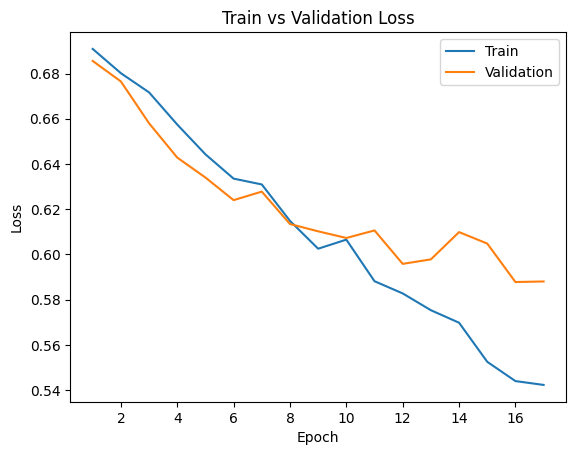

None


In [28]:
large_net = LargeNet()
train_net(large_net, 256, 0.025, 17)
model_path = get_model_name("large", batch_size=256, learning_rate=0.025, epoch=16)
print(plot_training_curve(model_path))

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [29]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=256, learning_rate=0.025, epoch=16)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

Based on the results from Part 2,3,4 above I chose large_net as it prodcues lower validation error and loss results as compared to small_net as seen in part 2d, and even though it overfits a bit more than small_net, this can be avoided by the hyperparameter values mentioned below. Thus a better starting point overall.

I chose a batch_size of 256 as it did a good job of reducing the validation error/loss while ensuring that there was no obvious over/underfitting as seen in part 4c,d.

I chose 17 epochs as there is an instance of the beginnings of a overfitting stage at epoch 18 as seen in part 4a,b, so reducing to 17 epochs helps avoid this.

I chose a learning rate of 0.025 in order to initiate a quicker decrease in the loss, preventing any overfitting that might be left as seen in part 4c,d.

As observed in the results, the validation error is very similar to the default model and the validation loss is a lot lower (0.58 vs 0.64), thus avoiding overfitting and increasing validation accuracy.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [31]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=256)

#using the code from Lab 1 part 5 and tutorial notebooks
criterion = nn.BCEWithLogitsLoss()
testing_error, testing_loss = evaluate(net, test_loader, criterion)
print ("Testing error : ", testing_error)
print ("Testing loss : ", testing_loss)

Files already downloaded and verified
Files already downloaded and verified
Testing error :  0.304
Testing loss :  0.5875863283872604


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [32]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=256)

#using the code from Lab 1 part 5
criterion = nn.BCEWithLogitsLoss()
validation_error, validation_loss = evaluate(net, val_loader, criterion)
print ("Validation error : ", validation_error)
print ("Validation loss : ", validation_loss)

Files already downloaded and verified
Files already downloaded and verified
Validation error :  0.3025
Validation loss :  0.5869087502360344


The test classification error of 0.304 is slightly higher than the validation error of 0.3025. This is because the way we tuned our hyperparameters was to ensure that the validation error was lowered as much as possible based on the various results seen in the previous parts. Also the model has continuously been exposed to the training and validation data in an attempt to maximize its accuracy on unseen data like the testing data. This has allowed the model to familiarize itself with the images in the training and validation sets a lot more than it has with the testing set which it has only seen once. The testing error is a real indication of the model performance in a real world setting, and thus it would be slightly higher than the validation error which the model has based its predictions on.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

The test data was only used at the very end to ensure that the model did not familiarize itself to it. This is an accurate measure of how the model would perform in a real world setting on data it has never seen before, allowing us to get the true performance. Doing so also allows us to not tune the hyperparameters in such a way that they overfit themselves to the testing data while training the model and produce biased results, giving us an inaccurate measure of the true model performance.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.422625, Train loss: 0.6703135017305613 |Validation err: 0.406, Validation loss: 0.6593176648020744
Epoch 2: Train err: 0.3765, Train loss: 0.6428378708660603 |Validation err: 0.392, Validation loss: 0.6551310867071152
Epoch 3: Train err: 0.36075, Train loss: 0.6283104512840509 |Validation err: 0.3815, Validation loss: 0.6444747820496559
Epoch 4: Train err: 0.340875, Train loss: 0.6146906968206167 |Validation err: 0.3975, Validation loss: 0.6585051268339157
Epoch 5: Train err: 0.336875, Train loss: 0.6078445799648762 |Validation err: 0.384, Validation loss: 0.6510740369558334
Epoch 6: Train err: 0.32525, Train loss: 0.597529336810112 |Validation err: 0.39, Validation loss: 0.6557098105549812
Epoch 7: Train err: 0.312375, Train loss: 0.5838396530598402 |Validation err: 0.3785, Validation loss: 0.6579889133572578
Epoch 8: Train err: 0.297, Train loss: 0.571203300729394 |Validation err: 0.3685

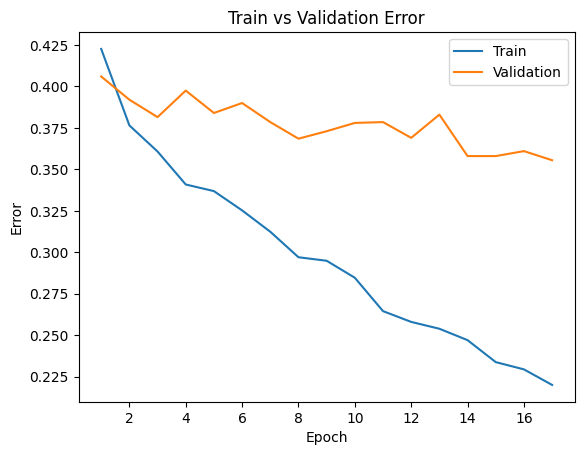

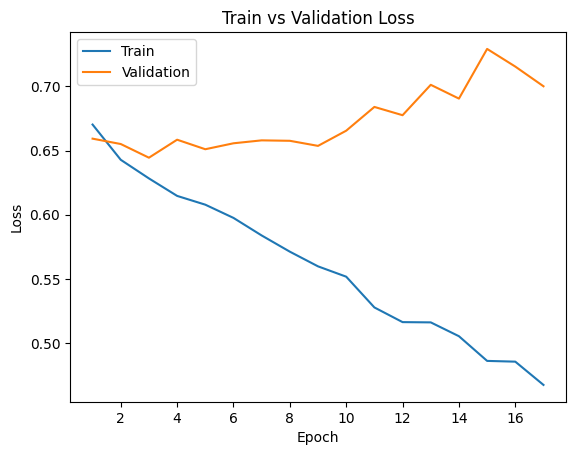

Files already downloaded and verified
Files already downloaded and verified
Testing error :  0.3595
Testing loss :  0.7043357640504837


In [39]:
#using code from Lab 1 to compare CNN model to 2-layer ANN model (Pigeon)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon_ANN"
        #flattening the RGB scale tensors
        self.layer1 = nn.Linear(32*32*3, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
       #flattening the RGB scale tensors
        flattened = img.view(-1, 32*32*3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        #using the squeeze function on tensors to concatenate them for the ANN
        activation2 = activation2.squeeze(1)
        return activation2

pigeon_ANN = Pigeon()

train_net(pigeon_ANN, 256, 0.025, 17)
model_path = get_model_name("pigeon_ANN", batch_size=256, learning_rate=0.025, epoch=16)
plot_training_curve(model_path)

# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=256)

#using the code from Lab 1 part 5
criterion = nn.BCEWithLogitsLoss()
testing_error, testing_loss = evaluate(pigeon_ANN, test_loader, criterion)
print ("Testing error : ", testing_error)
print ("Testing loss : ", testing_loss)

The 2-layer ANN model perfoms worse than the CNN model as it produces a higher testing error (0.304 vs 0.3595) and also a higher testing loss (0.58 vs 0.70). These classification readings indicate that there is a presence of overfitting on validation data, as is also confirmed by the increase in validation loss with increasing epochs even when the error is reducing. Thus the CNN model performs significantly better and should be the best choice for the dogs vs cats classification dataset.